In [2]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

## Reading the data files
Here we are only reading the files of the variables we ares interested in.

In [3]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
all_files = glob.glob(os.path.join(path , '*indresp.dta'))
raw_colnames = ['hidp',
                'sex',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'fimnlabgrs_dv',
                'fimnlabnet_dv',
                'istrtdatm',
                'istrtdaty']
indresp = []
prefixes = [] # for later
for filename in all_files:
    prefix = filename.split('/')[-1][0:2]
    prefixes.append(prefix)
    colnames = [f'{prefix}{x}' for x in raw_colnames]
    df = pd.read_stata(filename,
                       columns=['pidp'] + colnames)
    indresp.append(df)

## Concatenating the files by pidp
`pidp` is the unique identifiers of the person in each data file. Here, we are performing "first wave is key" merge.

In [4]:
indresp_df = indresp[0]['pidp']
for df in indresp:
    indresp_df = pd.merge(indresp_df, df, on='pidp', how='left')

### General overview of `aidhh`: 'cares for sick/disabled/elderly in household'; `aidxhh`: non-residents cared for, across the 12 waves.

Below we are doing some house keeping first, homologating all value labels across waves

In [5]:
indresp_df = indresp_df.replace({'Yes': 'yes', 'No': 'no', 'no     ': 'no', 'yes    ': 'yes'})

Now we procede to plot the evolution on valid cases per wave:

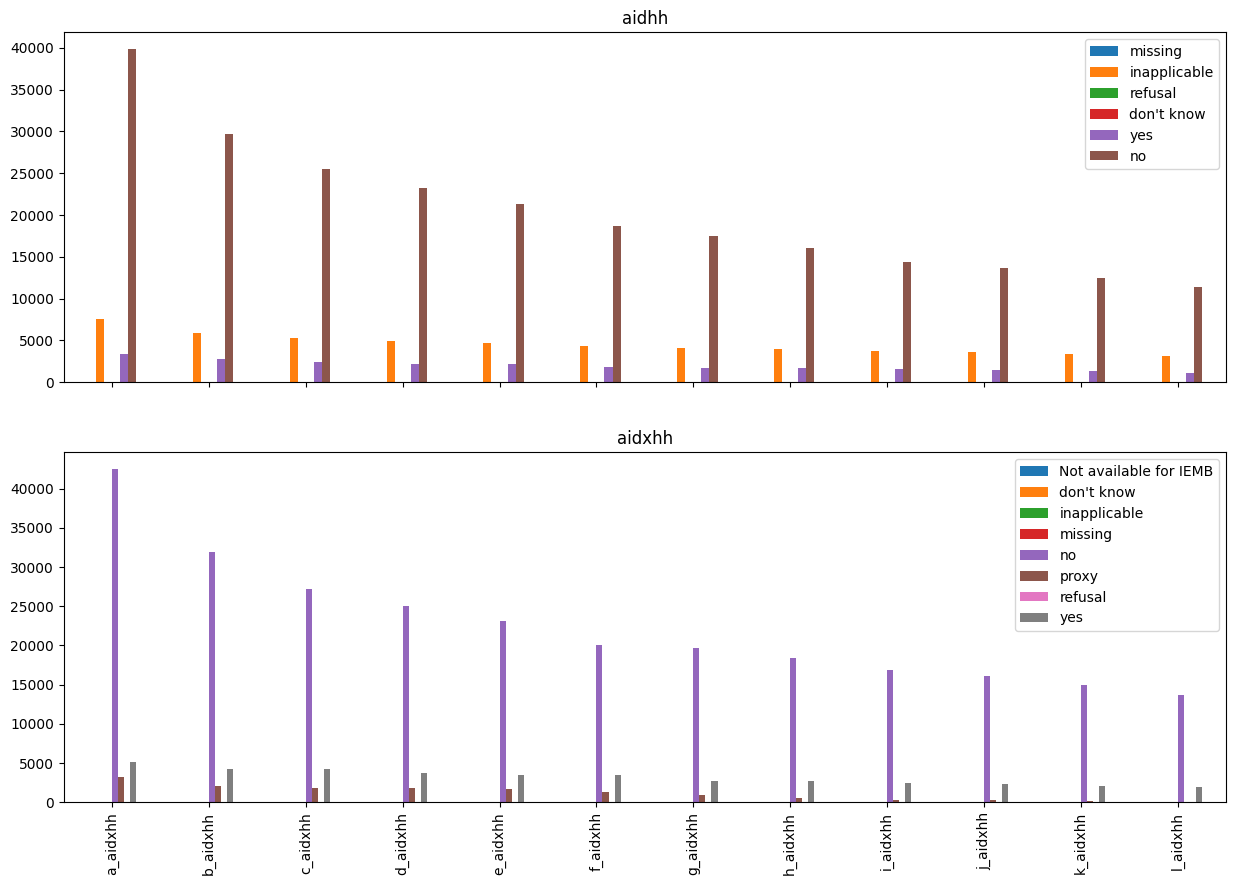

In [6]:
aidhh = []
aidxhh = []
for colname in indresp_df.columns:
    if 'aidhh' in colname:
        aidhh.append(colname)
    if 'aidxhh' in colname:
        aidxhh.append(colname)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
indresp_df[aidhh].apply(pd.Series.value_counts).T.plot.bar(ax=ax1)
indresp_df[aidxhh].apply(pd.Series.value_counts).T.plot.bar(ax=ax2)
ax1.set_title('aidhh')
ax2.set_title('aidxhh')
plt.show()

As it can be seen above, the valid sample of the cohort of the first wave goes from around 50k to 15k. Still a considerable sample size. Another interesting note is that carers raw number seems to be dropping lerss than non-carers raw number. And important note, the missing label correspond to 'missing at the time of the interview' and not a dropped case.

### Normalised count
Below the plots show the counts of the variables `aidhh` and `aidxhh` but now nomralise by sample size.

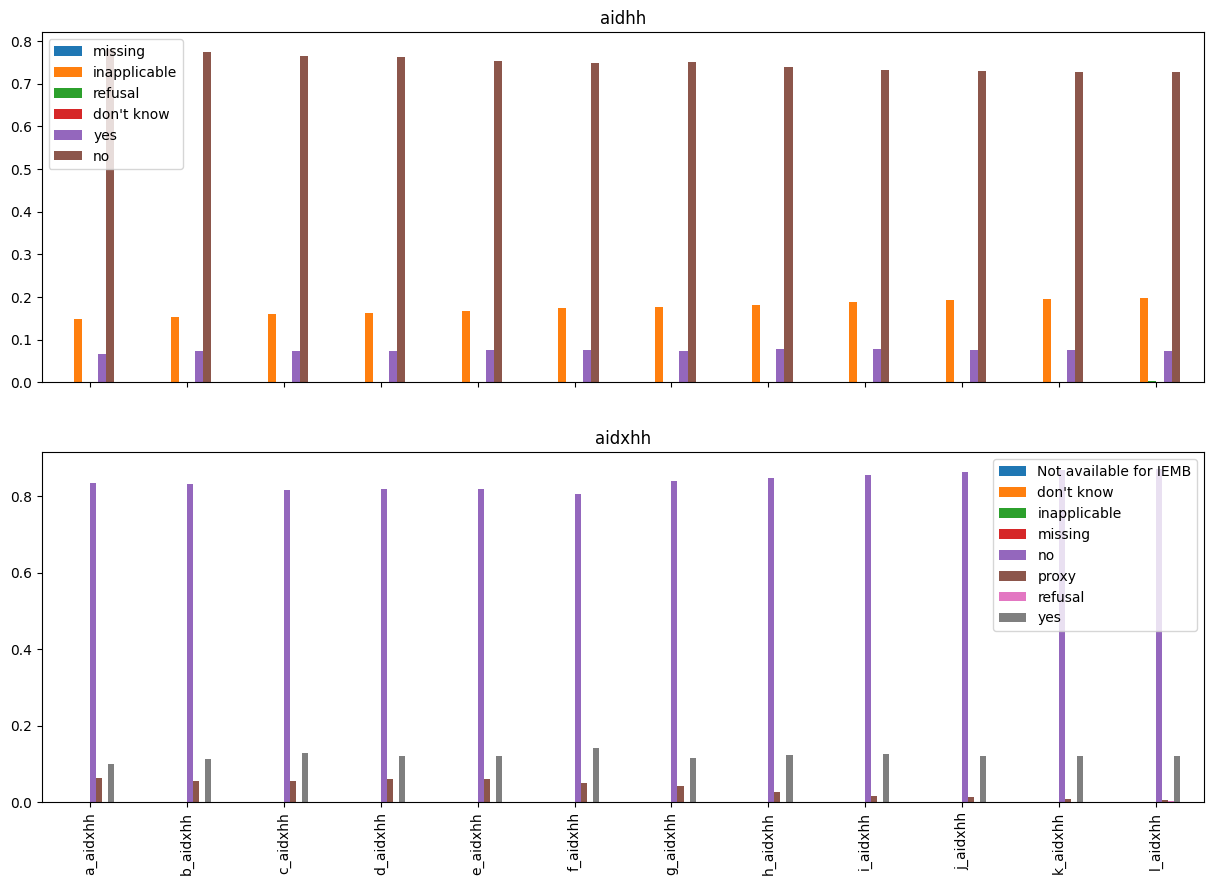

In [7]:
aidhh = []
aidxhh = []
for colname in indresp_df.columns:
    if 'aidhh' in colname:
        aidhh.append(colname)
    if 'aidxhh' in colname:
        aidxhh.append(colname)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
indresp_df[aidhh].apply(pd.Series.value_counts, normalize=True).T.plot.bar(ax=ax1)
indresp_df[aidxhh].apply(pd.Series.value_counts, normalize=True).T.plot.bar(ax=ax2)
ax1.set_title('aidhh')
ax2.set_title('aidxhh')
plt.show()

## Wage variables overview

Wage columns in the original dataset are store as a category in order to include other responses types in the question (e.g. refusal, don't know, etc). This must be recoded. Aditionally, wage must be corrected by inflation. Correction by inflation folows the following formula:
$$
adjwage_{i\tau} = \frac{wage_{i\tau} \times CPIH_{T}}{CPIH_{\tau}}
$$
Where $i$ represent the participant and $\tau$ the date of survey, being $T$ the current date.

In [8]:
cpih = pd.read_csv('./cpih_uk_88_23.csv')
cpih['date'] = pd.to_datetime(cpih.date, format='%b-%y')
dfs_list = []
# This loop is a monstruosity! I need to redo the way I prepare and clean the data.
for i, _ in enumerate(indresp):
    indresp[i][prefixes[i] + 'fimnlabnet_dv'] = pd.to_numeric(indresp[i][prefixes[i] + 'fimnlabnet_dv'], errors='coerce')
    indresp[i][prefixes[i] + 'fimnlabnet_dv'] = indresp[i][prefixes[i] + 'fimnlabnet_dv'].where(indresp[i][prefixes[i] + 'fimnlabnet_dv'] >= 0)
    indresp[i][prefixes[i] + 'fimnlabgrs_dv'] = pd.to_numeric(indresp[i][prefixes[i] + 'fimnlabgrs_dv'], errors='coerce')
    indresp[i][prefixes[i] + 'fimnlabgrs_dv'] = indresp[i][prefixes[i] + 'fimnlabgrs_dv'].where(indresp[i][prefixes[i] + 'fimnlabgrs_dv'] >= 0)
    indresp[i][prefixes[i] + 'istrtdaty'] = indresp[i][prefixes[i] + 'istrtdaty'].replace({'inapplicable': np.nan, 'missing': np.nan, "don't know": np.nan})
    indresp[i][prefixes[i] + 'istrtdatm'] = indresp[i][prefixes[i] + 'istrtdatm'].replace({'inapplicable': np.nan, 'missing': np.nan, "don't know": np.nan})
    indresp[i]['date'] = indresp[i][prefixes[i] + 'istrtdaty'].astype(str)+'/'+indresp[i][prefixes[i] + 'istrtdatm'].astype(str)
    indresp[i]['date'] = indresp[i]['date'].replace({'nan/nan': np.nan})
    indresp[i]['date'] = pd.to_datetime(indresp[i]['date'], format='%Y/%B')
    indresp[i] = indresp[i].merge(cpih, on='date', how='left')
    indresp[i][prefixes[i] + 'wage_gross_cpih_ad'] = (indresp[i][prefixes[i] + 'fimnlabgrs_dv'].astype(float) * 124.8) / indresp[i]['cpih']
    indresp[i][prefixes[i] + 'wage_net_cpih_ad'] = (indresp[i][prefixes[i] + 'fimnlabnet_dv'].astype(float) * 124.8) / indresp[i]['cpih']
    indresp[i] = indresp[i].drop(columns=['date', 'cpih'])

In [9]:
cpih = pd.read_csv('./cpih_uk_88_23.csv')
cpih['date'] = pd.to_datetime(cpih.date, format='%b-%y')

In [10]:
df = indresp[0]
df

,pidp,a_hidp,a_sex,a_ethn_dv,a_dvage,a_mastat_dv,a_country,a_aidhh,a_aidhrs,a_aidxhh,a_fimnlabgrs_dv,a_fimnlabnet_dv,a_istrtdatm,a_istrtdaty,a_wage_gross_cpih_ad,a_wage_net_cpih_ad
0,68001367,68001363,male,british/english/scottish/welsh/northern irish,39,Single and never married/in civil partnership,England,inapplicable,inapplicable,no,1900.000000,1400.000000,January,2009,2738.106236,2017.551963
1,68004087,68004083,male,any other white background,59,Divorced,England,inapplicable,inapplicable,no,1075.000000,800.000000,January,2009,1549.191686,1152.886836
2,68006127,68006123,female,british/english/scottish/welsh/northern irish,39,Living as couple,England,no,inapplicable,no,0.000000,0.000000,January,2009,0.000000,0.000000
3,68006135,68006123,female,british/english/scottish/welsh/northern irish,17,Single and never married/in civil partnership,England,no,inapplicable,no,0.000000,0.000000,January,2009,0.000000,0.000000
4,68006807,68006803,female,british/english/scottish/welsh/northern irish,72,Divorced,England,inapplicable,inapplicable,no,0.000000,0.000000,January,2009,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50989,1634643847,1634643843,female,bangladeshi,38,Married,England,no,inapplicable,no,0.000000,0.000000,February,2011,0.000000,0.000000
50990,1634644527,1634644523,male,bangladeshi,33,Married,England,no,inapplicable,no,427.109985,416.709991,February,2011,577.500825,563.438862
50991,1634644531,1634644523,female,bangladeshi,30,Married,England,no,inapplicable,no,0.000000,0.000000,February,2011,0.000000,0.000000
50992,1634649967,1634649963,male,pakistani,22,Married,England,no,inapplicable,no,450.000000,450.000000,February,2011,608.450704,608.450704


In [11]:
total = indresp[0]['pidp']
for df in indresp:
    total = pd.merge(total, df, on='pidp', how='left')

The above code first convert the columns to numeric and then recode all negative values to NaN so it can ignored. 

The code below, on the other hand selects the net and and the gross columns and computes the average wage per wave, excluding the people reporting 0 wage.

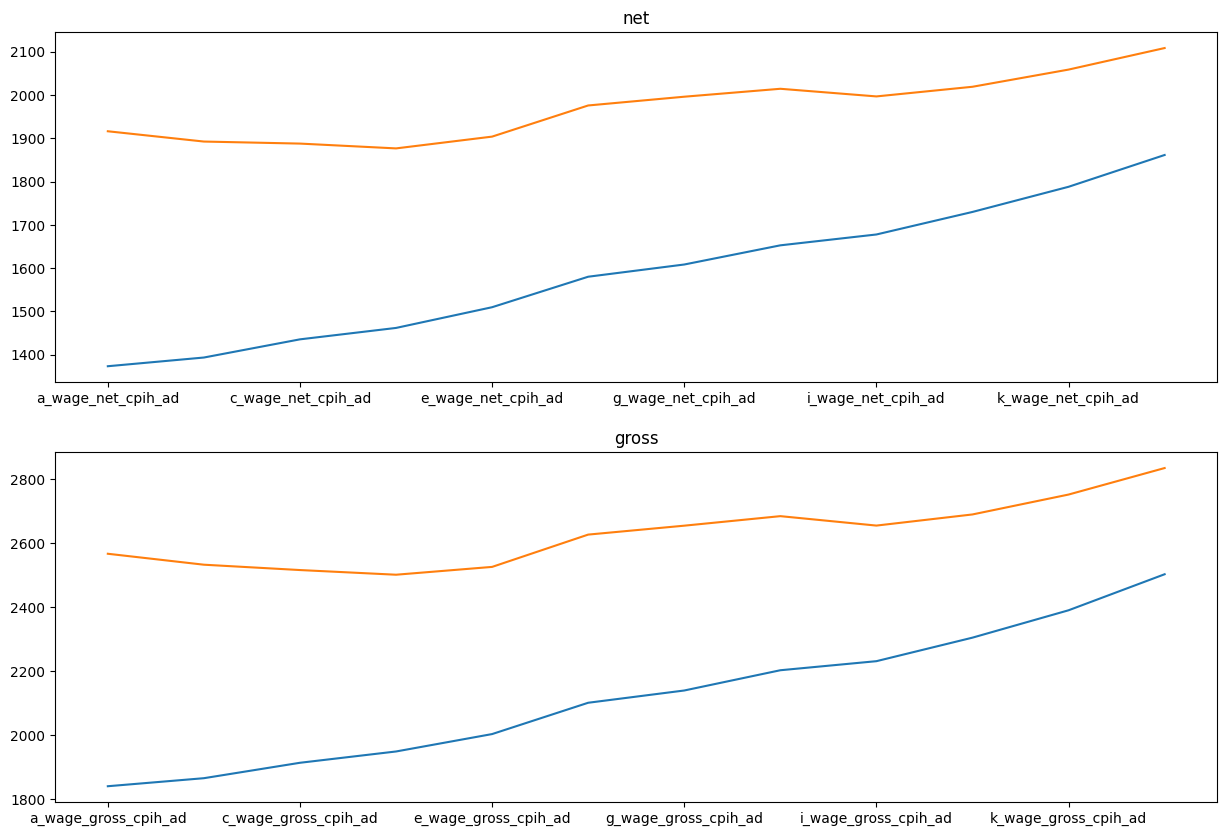

In [12]:
net = []
gross = []
net_ad = []
gross_ad = []
for colname in total.columns:
    if 'fimnlabnet_dv' in colname:
        net.append(colname)
    if 'fimnlabgrs_dv' in colname:
        gross.append(colname)
    if 'wage_gross_cpih_ad' in colname:
        gross_ad.append(colname)
    if 'wage_net_cpih_ad' in colname:
        net_ad.append(colname)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
total[net].where(total[net] > 0).apply(pd.Series.mean).T.plot(ax=ax1)
total[gross].where(total[gross] > 0).apply(pd.Series.mean).T.plot(ax=ax2)
total[net_ad].where(total[net_ad] > 0).apply(pd.Series.mean).T.plot(ax=ax1)
total[gross_ad].where(total[gross_ad] > 0).apply(pd.Series.mean).T.plot(ax=ax2)
ax1.set_title('net')
ax2.set_title('gross')
plt.show()

As it can be seen above net wages go from a little below 1400 pounds in the first wave, to iust below 1900 in the last wave, where the gross wages go from below 1900 to around 2500 pounds, in the unadjusted version (blue line). In the adjusted version the variation is between 1900 and 2100 pound for the net wage, and 2600 to 2800 for the gross wage.

# Maximising sample size

Giving that there is multiple waves in the survey, and that each wave does add a reinforcement sample, it is reasanoble to ask which combination of waves maximises the sample size.
We are going to put some restriction to the process:
- We will not skip waves. No 1-3-5...N merges.
- We will restrict the minumin waves number to be 6.

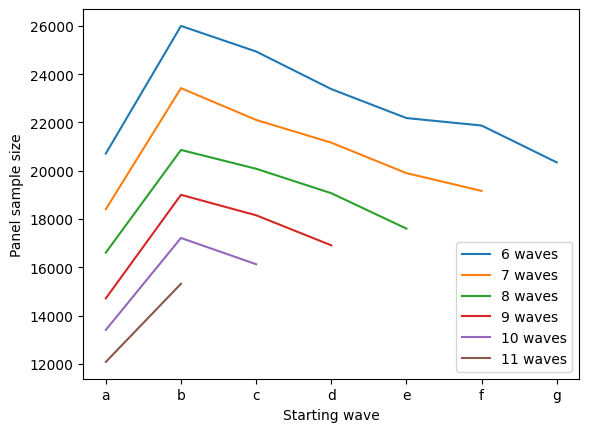

In [13]:
# this three level for loop is only (barely) justified in low data, low overhead situations like this one. Avoid.
legends = []
for size in range(6,12):
    lst = list(range(0,12))
    num_iterations = len(lst) - size + 1
    panel_cases_n = []
    for i in range(0, num_iterations):
        window = indresp[i:size + i]
        total = window[0]['pidp']
        for df in window:
            total = pd.merge(total, df, on='pidp', how='left')
        n = total.dropna().shape[0]
        panel_cases_n.append(n)
    legends.append(f'{size} waves')
    plt.plot(panel_cases_n)
plt.ylabel('Panel sample size')
plt.xticks(list(range(0, 7)), ['a', 'b', 'c', 'd', 'e', 'f', 'g'])
plt.xlabel('Starting wave')
plt.legend(legends)

As can be seen in the above plot, as we increase the amount of waves in the panel merge, the panel sample size decreases.
Additionally, using wave b (second) as the starting point of the panel merge maximises the sample size in all cases.

In [14]:
df_aidhh = indresp[0]['pidp']
for df in indresp:
    for colname in df.columns:
        if 'aidhh' in colname:
            aidhh = colname
            df_aidhh = pd.merge(df_aidhh, df[['pidp', aidhh]], on='pidp', how='left')

In [15]:
df_aidhh = df_aidhh.drop('a_aidhh', axis=1).replace({'Yes': 'yes',
                                                     'No': 'no',
                                                     'no     ': 'no',
                                                     'yes    ': 'yes',
                                                     'inapplicable': 'no',
                                                     "don't know": 'no',
                                                     'missing': np.nan,
                                                     'refusal': 'no'})

In [16]:
df_aidhh = df_aidhh.set_index('pidp')
df_aidhh

,b_aidhh,c_aidhh,d_aidhh,e_aidhh,f_aidhh,g_aidhh,h_aidhh,i_aidhh,j_aidhh,k_aidhh,l_aidhh
pidp,,,,,,,,,,,
68001367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68004087,no,no,no,no,no,no,no,no,no,NaN,NaN
68006127,no,yes,yes,yes,yes,yes,yes,yes,yes,yes,NaN
68006135,NaN,no,yes,yes,NaN,no,NaN,NaN,NaN,NaN,NaN
68006807,no,no,no,no,no,no,no,no,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1634643847,NaN,no,no,no,no,no,NaN,NaN,NaN,NaN,NaN
1634644527,no,no,no,NaN,no,no,no,no,no,no,no
1634644531,no,no,no,NaN,no,no,no,no,no,no,no


In [17]:
for column in df_aidhh:
    df_aidhh[column] = df_aidhh[column].cat.codes

In [18]:
df_aidhh = df_aidhh.replace({0:1, 1:0})

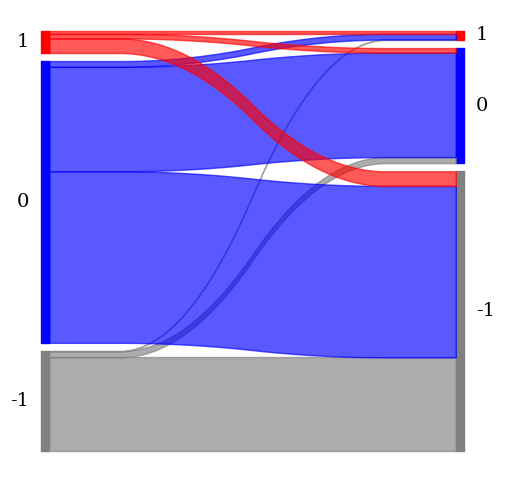

In [49]:
from pySankey import sankey

colorDict = {1: 'red',
            0: 'blue',
            -1: 'grey'}

sankey.sankey(df_aidhh['b_aidhh'], df_aidhh['l_aidhh'], colorDict=colorDict)